In [147]:
# numpy and pandas for data manipulation
import sys
# Suppress warnings
import warnings
import seaborn as sns
import matplotlib as plt
import networkx as nx
import numpy as np
import pandas as pd
import os
import matplotlib2tikz
plt.style.use('seaborn')
sns.set(style="whitegrid")
sns.set_context("paper", font_scale=2.5)
plt.rc('hatch', color='white', linewidth=1)
plt.rcParams.update({
    "font.family": "serif",
     "font.serif": [] ,
      "font.sans-serif": ["Linux Biolinum"]  })

warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline
ROOT_RESULT_FOLDER = '/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/experiment_results/local'


SYSTEM_COLOR = sns.color_palette()[0]
BASELINE_COLOR = sns.color_palette()[1]

WRITE_DIRECTORY_ROOT = \
'/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/papers/images/experiment-results'

output_directory = WRITE_DIRECTORY_ROOT + '/kaggle_home_credit/materialization'
def create_folder(path):
    if not os.path.exists(os.path.dirname(path)):
        try:
            os.makedirs(os.path.dirname(path))
        except OSError as exc:  # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise

In [148]:
result_folder = ROOT_RESULT_FOLDER + '/materialization/kaggle_home_credit'
result_file = result_folder + '/2019-10-02.csv'

In [149]:
HEADERS = [
    'timestamp', 'exp_id', 'repo', 'workload', 'mat_type','budget', 'total_mat', 'total_size','run_time'
]
materialization_result = pd.read_csv(result_file, header=None, names=HEADERS)
materialization_result[['budget', 'total_mat', 'total_size']] = materialization_result[['budget', 'total_mat', 'total_size']] / (1024. * 1024.)

In [150]:
materialization_result

,timestamp,exp_id,repo,workload,mat_type,budget,total_mat,total_size,run_time
0,10:52:47,4BA656BC,kaggle_home_credit,start_here_a_gentle_introduction,simple,5.0,4.905914,5.288049,53.305524
1,10:52:47,4BA656BC,kaggle_home_credit,introduction_to_manual_feature_engineering,simple,5.0,4.999921,8.734829,12.993557
2,10:52:47,4BA656BC,kaggle_home_credit,introduction_to_manual_feature_engineering_p2,simple,5.0,4.999999,35.590206,173.891762
3,10:52:47,4BA656BC,kaggle_home_credit,fork_cridata_start_here_a_gentle_introduction,simple,5.0,4.999999,35.590206,4.822310
4,10:52:47,4BA656BC,kaggle_home_credit,fork_taozhongxiao_start_here_a_gentle_introduc...,simple,5.0,3.981959,35.742448,14.106881
5,11:04:01,9E2920F0,kaggle_home_credit,start_here_a_gentle_introduction,storage_aware,5.0,5.288049,5.288049,52.241725
6,11:04:01,9E2920F0,kaggle_home_credit,introduction_to_manual_feature_engineering,storage_aware,5.0,8.734829,8.734829,12.834024
7,11:04:01,9E2920F0,kaggle_home_credit,introduction_to_manual_feature_engineering_p2,storage_aware,5.0,15.682864,35.590206,176.359839
8,11:04:01,9E2920F0,kaggle_home_credit,fork_cridata_start_here_a_gentle_introduction,storage_aware,5.0,17.308801,35.590206,2.215758
9,11:04:01,9E2920F0,kaggle_home_credit,fork_taozhongxiao_start_here_a_gentle_introduc...,storage_aware,5.0,17.461044,35.742448,13.296440


In [151]:
def plot_execution_time(df, loc=''):
    cat = sns.catplot(
        data=df,
        x='budget',
        y='run_time',
        hue='mat_type',
        kind ='bar',
        ci=99,
        hue_order=['simple', 'storage_aware'],
        palette={
            'storage_aware': SYSTEM_COLOR,
            'simple': BASELINE_COLOR
        },
        legend=False)
    #top = df['run_time'].max()
    #cat.set_axis_labels('Execution Number', 'Run Time (s)')
    cat.set_xlabels('Budget (GB)', fontsize=32)
    cat.set_ylabels('Total Run Time (s)', fontsize=32)
    #cat.set(ylim=(0, top + 100))
    plt.tick_params(labelsize = 28)
    
    num_executions = len(df.mat_type.unique())
    for i, bar in enumerate(cat.ax.patches):
        if i < num_executions:
            h = '/'
        else:
            h = 'x'
        bar.set_edgecolor('lightgray')
        bar.set_hatch(h)
        
    lg = plt.legend(loc='upper center', fontsize=28, ncol = 2, columnspacing=-1, bbox_to_anchor=(0.48,1.15))
    lg.legendHandles[0].xy = (45,0)
    lg.legendHandles[1].xy = (45,0)
    lg.legendHandles[0]._width = 31
    lg.legendHandles[1]._width = 31


    cat.savefig(loc)

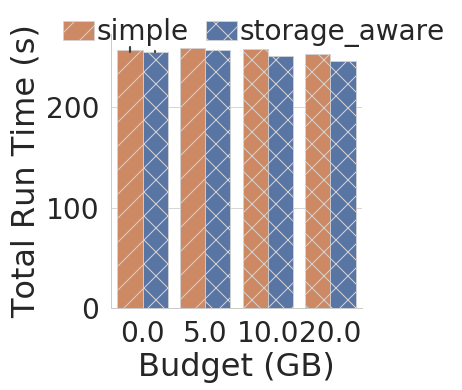

In [152]:
df = materialization_result.groupby(['exp_id','mat_type','budget'])['run_time'].sum().reset_index()
plot_execution_time(df)

In [153]:
def plot_sizes(df, loc=''):
    plot = sns.lineplot(
        data=df,
        x='workload_order',
        y='total_mat',
        hue='mat_type',
        style='mat_type',
        markers=["^", "o"],
        lw=3,
        hue_order=['simple', 'storage_aware'],
       # style_order = ['baseline', 'optimized'],
        dashes=[(2, 2), (1, 0)],
        palette={
            'storage_aware': SYSTEM_COLOR,
            'simple': BASELINE_COLOR
        },
        legend='full')

    legend = plot.legend()
    legend.texts[0].set_text("")
    for line in legend.get_lines():
        line.set_linewidth(3.0)
    #top = df['run_time'].max()
    #cat.set_axis_labels('Execution Number', 'Run Time (s)')
    plot.set_xlabel('Workload', fontsize=22)
    plot.set_ylabel('Size in GB', fontsize=22)
    #plot.set_xlim((1,2))
   # plot.set_ylim((0,500))
#     plot.set_xticks(range(1,5))
#     plot.set_xticklabels([1,2, 3,4,5])
    plt.tight_layout()
    #plt.savefig(loc)

In [154]:
execution_order = {'start_here_a_gentle_introduction':1,
                   'introduction_to_manual_feature_engineering':2,
                   'introduction_to_manual_feature_engineering_p2':3,
                   'fork_cridata_start_here_a_gentle_introduction':4,
                   'fork_taozhongxiao_start_here_a_gentle_introduction':5
                  }
df = materialization_result[['exp_id','workload','mat_type','budget','total_mat','total_size']]
df['workload_order'] = df['workload'].replace(execution_order)

In [155]:
#plot_sizes(df[df['budget'] == 0.0])

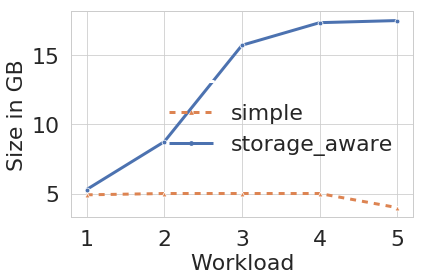

In [156]:
plot_sizes(df[df['budget'] == 5.0])

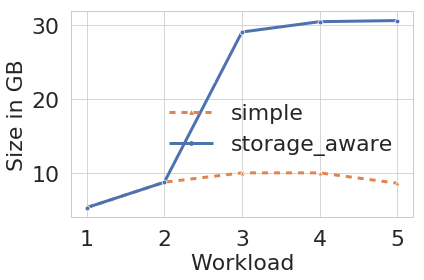

In [157]:
plot_sizes(df[df['budget'] == 10.0])

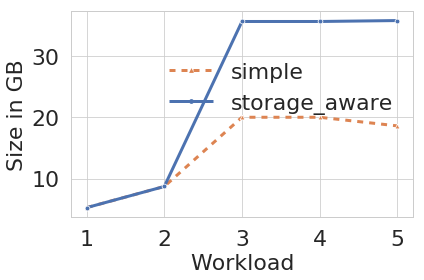

In [158]:
plot_sizes(df[df['budget'] == 20.0])